## Notebook :

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import scipy.io as io
from mpl_toolkits import mplot3d
import xarray as xr
import pandas as pd
import matplotlib as mpl
import h5py

In [2]:
#Path to data from moorings
path='/Users/zcaspar/Documents/Stage/grl/Data'

In [3]:
#Taille labels, legend des figures:
Size=18
mpl.rcParams['axes.labelsize']=Size
mpl.rcParams['xtick.labelsize']=Size
mpl.rcParams['ytick.labelsize']=Size
mpl.rcParams['legend.fontsize']=Size

In [4]:
#Extraction data (old version): 
def vari(f):
    """extrait les données de temperature potentielle, salinité, vitesses, densité, pression, temps et température in situ des fichiers de mouillages"""
    p=f['pgrid'][0,:]
    d=f['day'][:,0]
    T=xr.DataArray(f['THETA'][:],[('time',d),('pressure',p)])
    S=xr.DataArray(f['S'][:],[('time',d),('pressure',p)])
    u=xr.DataArray(f['U'][:],[('time',d),('pressure',p)])
    v=xr.DataArray(f['V'][:],[('time',d),('pressure',p)])
    sig=xr.DataArray(f['SIGTH'][:],[('time',d),('pressure',p)])
    t=xr.DataArray(f['T'][:],[('time',d),('pressure',p)])
    T.name='Potential temperature'
    S.name='Salinity'
    sig.name='Density'
    U=np.sqrt(u**2+v**2)
    return T,S,sig,u,v,U,p,d,t

def vari_v7(f):
    """ extrait les données de température potentielle, salinité, vitesses, densité, pression, temps et température in situ des fichiers de mouillages pour les fichiers .mat à partir de 2012"""
    p=f['pgrid'][:,0]
    d=f['day'][0,:]
    T=xr.DataArray(f['THETA'][:],[('pressure',p),('time',d)]).T
    S=xr.DataArray(f['S'][:],[('pressure',p),('time',d)]).T
    u=xr.DataArray(f['U'][:],[('pressure',p),('time',d)]).T
    v=xr.DataArray(f['V'][:],[('pressure',p),('time',d)]).T
    sig=xr.DataArray(f['SIGTH'][:],[('pressure',p),('time',d)]).T
    t=xr.DataArray(f['T'][:],[('pressure',p),('time',d)]).T
    T.name='Potential temperature'
    S.name='Salinity'
    sig.name='Density'
    U=np.sqrt(u**2+v**2)
    return T,S,sig,u,v,U,p,d,t

#Plot 3D first/last year
def Combine_debfin(moor,var):
    """combine données 1ere et dernière année de mesures mouillages A,B et D """
    if moor=='A':
        t=xr.DataArray(var[0],[('time',dA),('pressure',PA)])
        t1=xr.DataArray(var[1],[('time',dA1+1.5*365.),('pressure',PA1)])
    elif moor=='B':
        t=xr.DataArray(var[0],[('time',dB),('pressure',PB)])
        t1=xr.DataArray(var[1],[('time',dB1+1.5*365.),('pressure',PB1)])
    elif moor=='D':
        t=xr.DataArray(var[0],[('time',dD+2*365),('pressure',PD)])
        t1=xr.DataArray(var[1],[('time',dD1+3.5*365.),('pressure',PD1)])
    Tt=t.combine_first(t1)
    #Tt=Tt.resample(time='2D').asfreq()
    dd=Tt.coords['time'].values
    p=Tt.coords['pressure'].values
    return Tt,dd,p

def plot3d(moor,var,figsize,k):
    """plot 3D des données des 1ere et dernière années de mesures aux mouillages A,B et D.Prend en entrée le mouillage concerné, la variable voulue, la taille de la figure et tous les combien un profil sera tracé"""
    p=var.coords['pressure']
    D=var.coords['time'].values

    plt.figure(figsize=figsize)
    ax=plt.axes(projection='3d')

    for j in range(var.coords['time'].size):
        if j%k==0:
            dj=var.coords['time'].values[j]
            ax.plot(var.sel(time=dj,method='nearest').sel(pressure=slice(300,700)).where(var.sel(time=dj,method='nearest').sel(pressure=slice(300,700))>27.8),p.sel(pressure=slice(300,700)),dj,'k',zdir='y');ax.set_zlim([700,300])
    ax.set_xlabel('\n\nDensity (kg.m$^{-3}$)');ax.set_ylabel('Time',labelpad=40,rotation=40);ax.set_zlabel('\nPressure(dbar)')
    #ax.tick_params(axis='y',pad=40)
    if moor=='A':
        #emplacements des ticks sur l'axe du temps (y)
        Y=np.linspace(D.min(),dA.max(),5)#
        Y=np.concatenate((Y,np.linspace(DA[np.where(DA==dA.max())[0][0]+1],DA.max(),5)))#np.linspace(830,1176,5)))
        #
        Time=np.linspace(D.min(),dA.max(),5)#578,5)
        Time=np.concatenate((Time,np.linspace(dA1.min()+13*365,dA1.max()+13*365,5)))#np.linspace(5027,5375,5)))
    if moor=='B':
        Y=np.linspace(D.min(),dB.max(),5)#578,5)
        Y=np.concatenate((Y,np.linspace(DB[np.where(DB==dB.max())[0][0]+1],DB.max(),5)))#np.linspace(830,1176,5)))
        Time=np.linspace(D.min(),dB.max(),5)#578,5)
        Time=np.concatenate((Time,np.linspace(dB1.min()+14*365,dB1.max()+14*365,5)))
    if moor=='D':
        Y=np.linspace(D.min(),dD.max()+2*365,5)#578,5)
        Y=np.concatenate((Y,np.linspace(DD[np.where(DD==dD.max()+2*365)[0][0]+1],DD.max(),5)))#np.linspace(830,1176,5)))
        Time=np.linspace(D.min(),dD.max()+2*365,5)#578,5)
        Time=np.concatenate((Time,np.linspace(dD1.min()+14*365,dD1.max()+14*365,5)))
        
    lab=pd.to_datetime(Time,unit='D',origin='2003-01-01').strftime('%m-%y')
    ax.set_yticks(Y)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_yticklabels(lab)
    ax.get_yticklabels()[5].set_color('red')
    ax.get_yticklabels()[4].set_color('red')
    ax.set_xlim(left=27.8)
    #plt.yticks(ha='left')
    plt.setp(ax.yaxis.get_majorticklabels(),rotation=-25,ha='left',rotation_mode='anchor')
    plt.setp(ax.xaxis.get_majorticklabels(),rotation=15,ha='center',rotation_mode='anchor')
    return Y

In [5]:
#More efficient method to read data from mooring (not used yet for first/last years of data)
import datetime
def read_moors(file):
    """extrait les données de temperature potentielle, salinité, vitesses, densité, pression, temps et température in situ des fichiers de mouillages"""
    try: 
        f = io.loadmat(file)
    except:
        f = h5py.File(file)
    if len(f.keys())==0:
        pass
    else:
        p=f['pgrid'][:].reshape((f['pgrid'][:].size,))
        d=f['day'][:].reshape((f['day'][:].size,))
        origin = '20'+file[-14:-12]+'-01-01'
        time = pd.to_datetime(d,unit='D',origin=origin)
        T=xr.DataArray(f['THETA'][:].reshape((d.size,p.size)),[('time',time),('pressure',p)])
        S=xr.DataArray(f['S'][:].reshape((d.size,p.size)),[('time',time),('pressure',p)])
        u=xr.DataArray(f['U'][:].reshape((d.size,p.size)),[('time',time),('pressure',p)])
        v=xr.DataArray(f['V'][:].reshape((d.size,p.size)),[('time',time),('pressure',p)])
        sig=xr.DataArray(f['SIGTH'][:].reshape((d.size,p.size)),[('time',time),('pressure',p)])
        t=xr.DataArray(f['T'][:].reshape((d.size,p.size)),[('time',time),('pressure',p)])
        T.name='Potential_temperature'
        S.name='Salinity'
        sig.name='Density'
        u.name = 'u'
        v.name = 'v'
        U=np.sqrt(u**2+v**2)
        U.name = 'Velocity_magnitude'
     #   tst = xr.Dataset({'%s'%ds.name:ds for ds in [T,S,sig,u,v,U]})
        return xr.Dataset({'%s'%ds.name:ds for ds in [T,S,sig,u,v,U]})




### Read .mat files of first and last year of data for moorings A, B and D (C was not deployed again after XXXX)

In [6]:
#Mooring A
file=[path+'/bg0304_mmp_a.mat',path+'/bg1617_mmp_a.mat'] #path files
d0='2003-01-01' # Origin date
#Mooring B
fileb=[path+'/bg0304_mmp_b.mat',path+'/bg1718_mmp_b.mat']

#Mooring D
filed=[path+'/bg0506_mmp_d.mat',path+'/bg1718_mmp_d.mat']



#extraction of data we need (this method is highly unefficient and is changed for following parts of the notebook)
fa = io.loadmat(file[0])
fa1 = h5py.File(file[1])
fb = io.loadmat(fileb[0])
fb1 = h5py.File(fileb[1])
fd = io.loadmat(filed[0])
fd1 = h5py.File(filed[1])

Siga=vari(fa)[2]
dA=vari(fa)[-2]
PA=vari(fa)[-3]
Siga1=vari_v7(fa1)[2]
dA1=vari_v7(fa1)[-2]
PA1=vari_v7(fa1)[-3]

Sigb=vari(fb)[2]
dB=vari(fb)[-2]
PB=vari(fb)[-3]
Sigb1=vari_v7(fb1)[2]
dB1=vari_v7(fb1)[-2]
PB1=vari_v7(fb1)[-3]

Sigd=vari(fd)[2]
dD=vari(fd)[-2]
PD=vari(fd)[-3]
Sigd1=vari_v7(fd1)[2]
dD1=vari_v7(fd1)[-2]
PD1=vari_v7(fd1)[-3]


### Plot of the first and last years of data for moorings A, B and D

Text(0.5, 0.92, 'Mooring A : Differences first year/last year ')

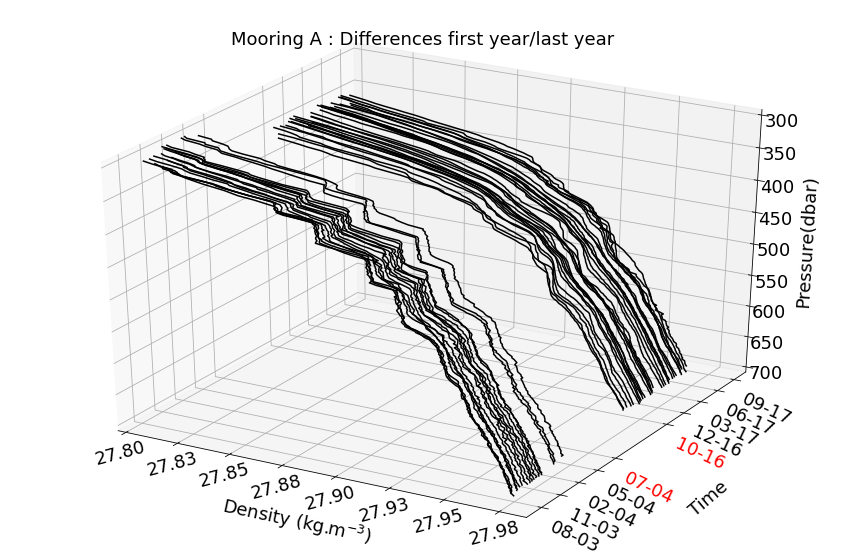

In [12]:
#Combinaison et plot :
siga=[Siga,Siga1]
SigA,DA=Combine_debfin('A',siga)[:2]
Y=plot3d('A',SigA,(15,10),10)
plt.title('Mooring A : Differences first year/last year ',size=Size)

Text(0.5, 0.92, 'Mooring B : Differences first year/last year ')

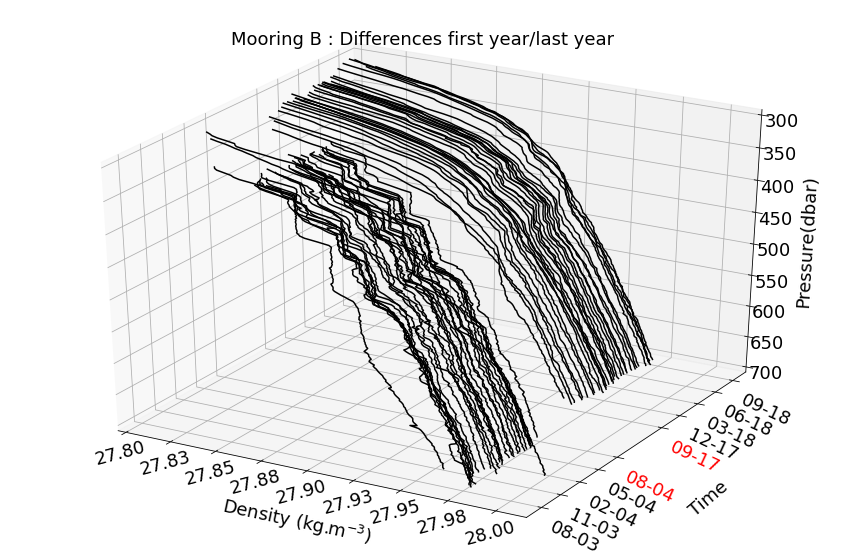

In [58]:
sigb=[Sigb,Sigb1]
SigB,DB=Combine_debfin('B',sigb)[:2]
Y=plot3d('B',SigB,(15,10),10)
plt.title('Mooring B : Differences first year/last year ',size=Size)

Text(0.5, 0.92, 'Mooring D : Differences first year/last year ')

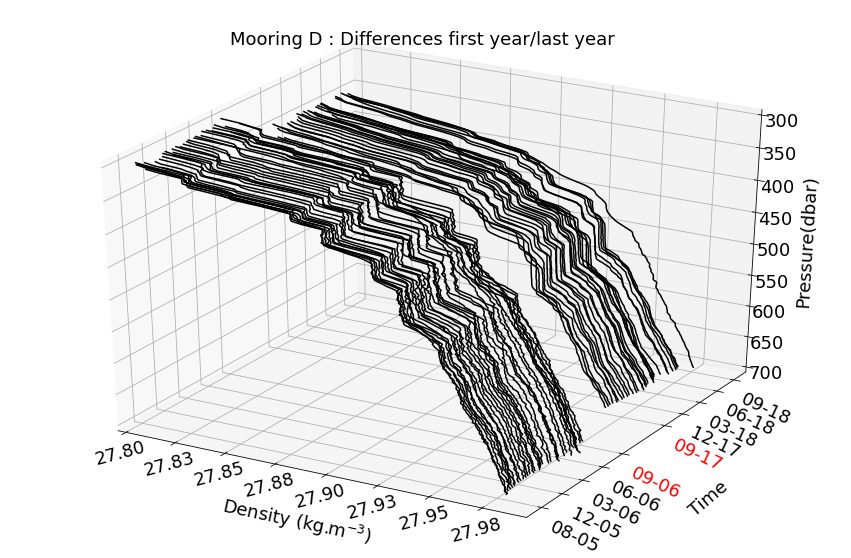

In [13]:
sigd=[Sigd,Sigd1]
SigD,DD=Combine_debfin('D',sigd)[:2]
Y=plot3d('D',SigD,(15,10),10)
plt.title('Mooring D : Differences first year/last year ',size=Size)

In [7]:
import matplotlib.dates as dates


def fig_3D(ds,figsize,p0,p1,k):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111,projection='3d')
    tps = []
    for t in ds.time.values[::k]:
        ax.plot(ds.Density.sel(time=t).values.reshape(ds.sel(time=t).pressure.values.size,1),
                ds.sel(time=t).pressure.values.reshape(ds.sel(time=t).pressure.values.size,1),
                dates.date2num(t),'k',zdir='y'
                )
        tps.append(str(t)[:10])
    ax.set_zlim(p1,p0)
    #ax.set_yticks(Y)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    y = ax.get_yticks()
    ax.set_yticklabels([dates.num2date(Y).strftime('%Y-%m') for Y in y])
    plt.setp(ax.yaxis.get_majorticklabels(),rotation=-25,ha='left',rotation_mode='anchor');
    plt.setp(ax.xaxis.get_majorticklabels(),rotation=15,ha='center',rotation_mode='anchor');
    fig.tight_layout()
    ax.set_xlabel('Density',labelpad=15);ax.set_ylabel('Time (date)',labelpad=50);
    ax.set_zlabel('Pressure (dbar)',labelpad=15)
 #   ax.view_init(30,-40)
    return ax

### Test section for first/last year (to be continued)

In [8]:
#Mooring A
file=[path+'/bg0304_mmp_a.mat',path+'/bg1617_mmp_a.mat'] #path files
d0='2003-01-01' # Origin date
#Mooring B
fileb=[path+'/bg0304_mmp_b.mat',path+'/bg1718_mmp_b.mat']

#Mooring D
filed=[path+'/bg0506_mmp_d.mat',path+'/bg1718_mmp_d.mat']




In [9]:
casts_A = xr.concat([read_moors(f) for f in file], dim='time')
casts_B = xr.concat([read_moors(f) for f in fileb], dim='time')
casts_D = xr.concat([read_moors(f) for f in filed], dim='time')

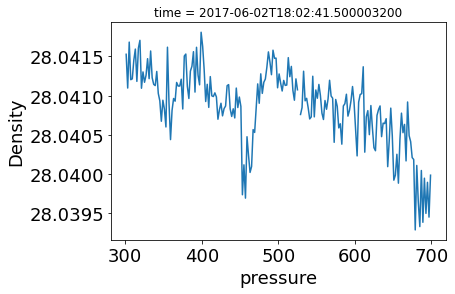

In [14]:
#casts_A.Density.sel(time=slice(datetime.datetime(2004,12,31),datetime.datetime(2015,12,31))).plot()#plot(y='pressure',yincrease=False)
casts_A.Density.isel(time=390).sel(pressure=slice(300,700)).plot()

In [ ]:
casts_A.Density.time.values#.sel(pressure=slice(300,700)).plot(y='pressure',yincrease=False)

In [15]:
casts_A

<xarray.Dataset>
Dimensions:                (pressure: 980, time: 488)
Coordinates:
  * pressure               (pressure) float64 47.0 49.0 ... 2.003e+03 2.005e+03
  * time                   (time) datetime64[ns] 2003-08-16T18:00:00 ... 2017-09-21T00:02:46.499971200
Data variables:
    Potential_temperature  (time, pressure) float64 nan nan nan ... nan nan nan
    Salinity               (time, pressure) float64 nan nan nan ... nan nan nan
    Density                (time, pressure) float64 nan nan nan ... nan nan nan
    u                      (time, pressure) float64 nan nan nan ... nan nan nan
    v                      (time, pressure) float64 nan nan nan ... nan nan nan
    Velocity_magnitude     (time, pressure) float64 nan nan nan ... nan nan nan

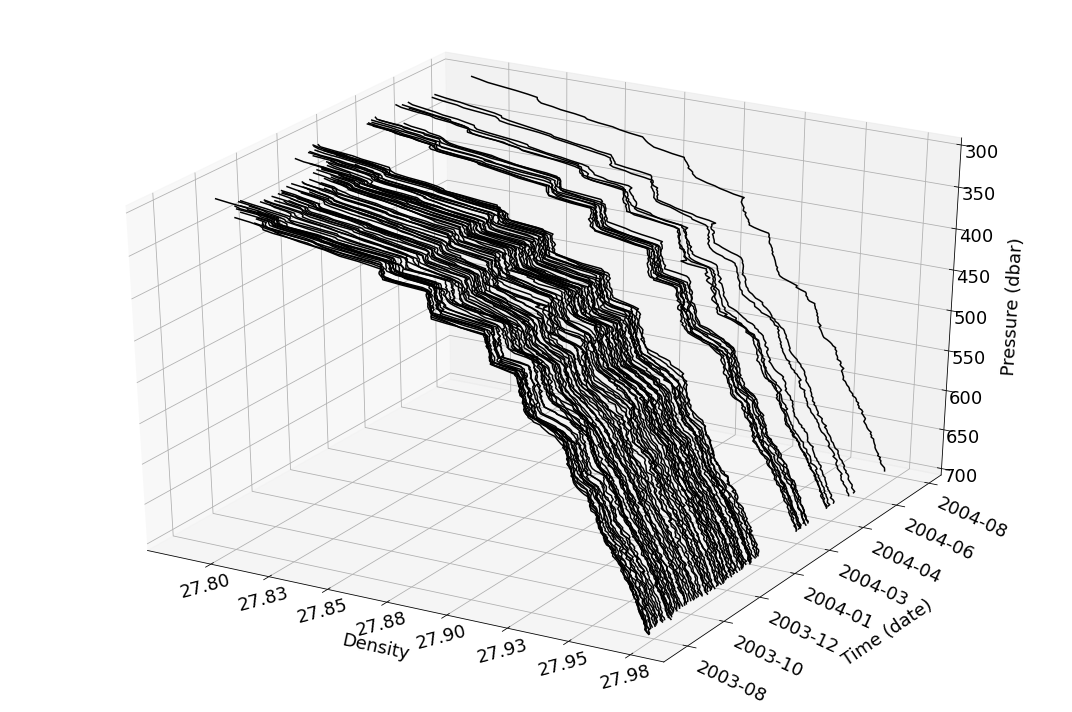

In [16]:
Y=fig_3D(casts_A.isel(time=slice(None,182)).sel(pressure=slice(300,700)),(15,10),300,700,2)

### End tests section

### Plot 3D mooring D

In [22]:
filed=[path+'/bg0506_mmp_d.mat',path+'/bg0607_mmp_d.mat']
casts_D = xr.concat([read_moors(f) for f in filed], dim='time')

Text(0.5, 0.92, 'Data from year 2006/2007 at mooring D')

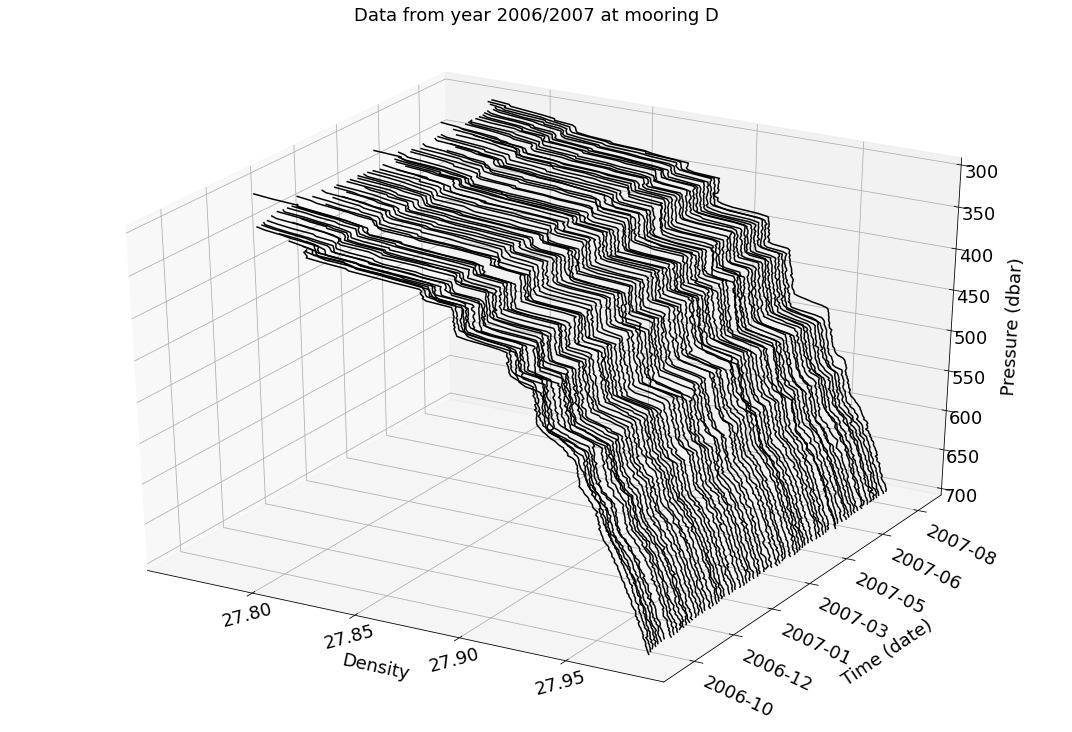

In [23]:
Y=fig_3D(casts_D.sel(time=slice(datetime.datetime(2006,10,1),datetime.datetime(2007,12,31))).sel(pressure=slice(300,700)),(15,10),300,700,4)
Y.set_title('Data from year 2006/2007 at mooring D',fontsize=Size)

In [10]:
#Mooring D:
fileD = path+'/bg0607_mmp_d.mat'
fD = io.loadmat(fileD)
sig_D = vari(fD)[2]
T_D = vari(fD)[0]
S_D = vari(fD)[1]
xx = genfig_3d(sig_D,(15,10),5,'2006-01-01')
plt.title('Data from year 2006/2007 at mooring D',size=Size)

NameError: name 'genfig_3d' is not defined

### Plot mean profiles of year 2006/2007 at mooring D + snapshots at mid time series (Fig1c)

In [28]:
casts_D#.Density.mean('time').sel(pressure=slice(300,700)).plot()

<xarray.Dataset>
Dimensions:                (pressure: 974, time: 645)
Coordinates:
  * pressure               (pressure) uint16 55 57 59 61 ... 1995 1997 1999 2001
  * time                   (time) datetime64[ns] 2005-08-30T06:00:00 ... 2007-08-23T18:00:00
Data variables:
    Potential_temperature  (time, pressure) float64 nan -0.9523 ... -0.5107 nan
    Salinity               (time, pressure) float64 nan 31.04 ... 34.94 nan
    Density                (time, pressure) float64 nan 24.94 ... 28.08 nan
    u                      (time, pressure) float64 nan -0.4188 ... nan nan
    v                      (time, pressure) float64 nan -20.19 ... nan nan
    Velocity_magnitude     (time, pressure) float64 nan 20.2 22.73 ... nan nan

In [11]:
#Mean :
Sigmean_D = sig_D.mean(axis=0)
Smean_D = S_D.mean(axis=0)
Tmean_D = T_D.mean(axis=0)

In [12]:
threshold_rho = 5e-4
th = 12
#ds_test = DS['1']
#dsi = ds_test.sel(levels=slice(300,700))
var = sig_D.isel(time=sig_D.time.size//2).sel(pressure=slice(300,700))
drho = var.differentiate('pressure')
rho_th = var.where(drho>threshold_rho,drop=True)
rho_g = rho_th.where(rho_th.pressure.diff(dim='pressure')>th,drop=True)
rho_g = xr.concat([rho_th[np.isin(rho_th.pressure.values,rho_g.pressure.values)],rho_th[np.roll(np.isin(rho_th.pressure.values,rho_g.pressure.values),-1)]],dim='pressure')
rho_g = rho_g.sortby('pressure')

#drho = sig_D.isel(time=sig_D.time.size//2).differentiate('pressure')


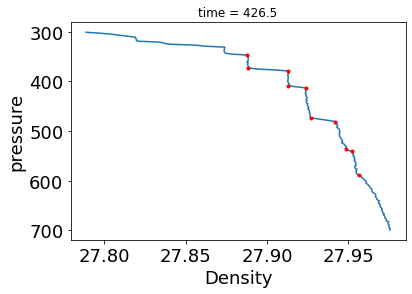

In [17]:
var.sel(pressure=slice(300,700)).plot(y='pressure',yincrease=False)
rho_g.plot.line('r.',y='pressure',yincrease=False,label='Steps points')

In [112]:
drho.sel(pressure=rho_g.pressure.values)

<xarray.DataArray 'Density' (pressure: 10)>
array([0.0026243 , 0.00136952, 0.00203062, 0.00119908, 0.00120567,
       0.00093161, 0.00105874, 0.00053063, 0.000588  , 0.00050798])
Coordinates:
    time      float64 426.5
  * pressure  (pressure) uint16 347 373 379 409 413 473 481 537 541 589

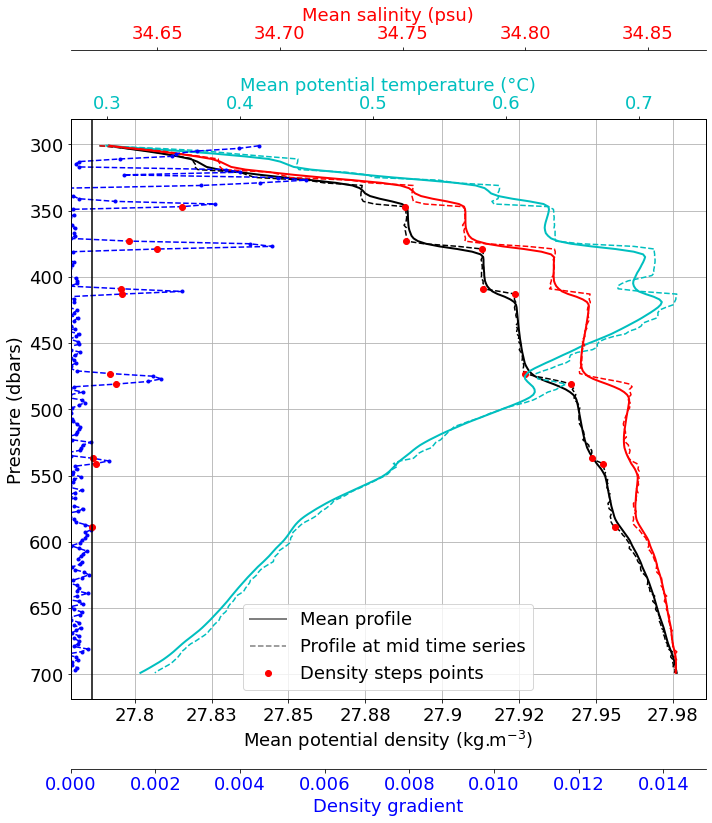

In [13]:
fig,ax=plt.subplots(figsize=(10,12))
Sigmean_D.sel(pressure=slice(300,700)).plot(ax=ax,y='pressure',yincrease=False,c='k',linewidth=2)
sig_D.isel(time=sig_D.time.size//2).sel(pressure=slice(300,700)).plot(ax=ax,y='pressure',yincrease=False,c='k',linestyle='--')
rho_g.plot.line('r.',markersize=12,y='pressure',yincrease=False,label='Steps points')
ax.set_xlabel(r'Mean potential density (kg.m$^{-3}$)',color='k');ax.set_ylabel('Pressure (dbars)')
lab = np.around(ax.get_xticks(),decimals=2)
ax.set_xticklabels(lab,color='k')
#ax.tick_params(axis='x', labelcolor='b')

ax1 = ax.twiny()
Tmean_D.sel(pressure=slice(300,700)).plot(ax=ax1,y='pressure',yincrease=False,c='c',linewidth=2)
T_D.isel(time=T_D.time.size//2).sel(pressure=slice(300,700)).plot(ax=ax1,y='pressure',yincrease=False,c='c',linestyle='--')


ax1.tick_params(axis='x', labelcolor='c')
ax1.set_xlabel(r'Mean potential temperature (°C)',color='c')

ax2 = ax.twiny()
ax2.spines["top"].set_position(("axes", 1.12))
ax2.spines["top"].set_visible(True)

Smean_D.sel(pressure=slice(300,700)).plot(ax=ax2,y='pressure',yincrease=False,c='r',linewidth=2)
S_D.isel(time=S_D.time.size//2).sel(pressure=slice(300,700)).plot(ax=ax2,y='pressure',yincrease=False,c='r',linestyle='--')


ax2.tick_params(axis='x', labelcolor='r')
ax2.set_xlabel(r'Mean salinity (psu)',color='r')
ax3 = ax.twiny()
ax3.xaxis.set_ticks_position('bottom')
ax3.xaxis.set_label_position("bottom")
ax3.spines["bottom"].set_position(("axes", -.12))
#ax3.spines[""].set_visible(True)

drho.sel(pressure=slice(300,700)).plot.line('b.-',ax=ax3,y='pressure',yincrease=False,linestyle='--')#,c='b',linestyle='--')
drho.sel(pressure=rho_g.pressure.values).plot.line('r.',markersize=12,y='pressure',yincrease=False,label='Steps points')
#S_D.isel(time=S_D.time.size//2).sel(pressure=slice(300,700)).plot(ax=ax2,y='pressure',yincrease=False,c='r',linestyle='--')


ax3.tick_params(axis='x', labelcolor='b')
ax3.set_xlabel(r'Density gradient',color='b');ax3.set_xlim(0,0.015)
#ax2.xaxis(r'Salinity (psu)',color='r',offset=30)
fig.tight_layout()
ax2.set_title('');ax1.set_title('');ax.set_title('');ax3.set_title('')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='grey', lw=2),
                Line2D([0], [0], color='grey',linestyle='--' ),
                Line2D([], [], color='r', marker='.', linestyle='None',markersize=12)]

ax.legend(custom_lines, ['Mean profile', 'Profile at mid time series','Density steps points'],loc=8)
ax.grid()
ax3.axvline(0.0005,c='k')
#ax.set_legend(custom_lines,labels)

### Plot TS diagram of mean salinity and temperature

(0.2, 0.8)

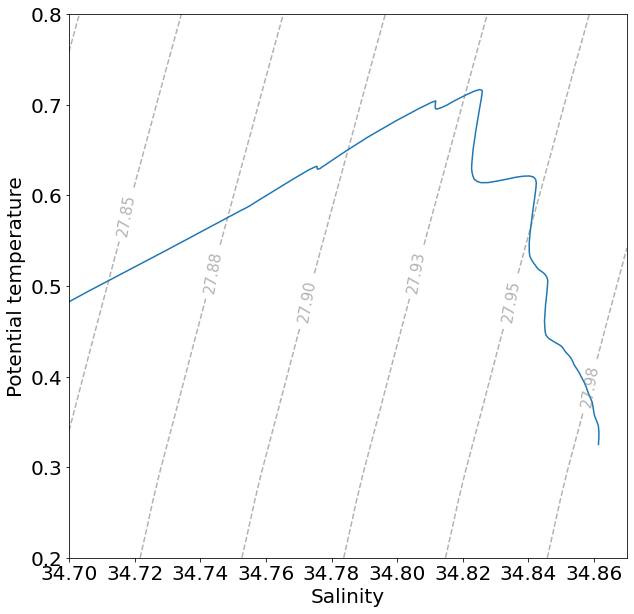

In [53]:
#TS diagram:
import numpy as np
import gsw
slim=[34.7,34.87]
tlim=[0.2,0.8]
P = Smean_D.coords['pressure'].values
SAmean = gsw.SA_from_SP(Smean_D,P,-150,74)

fig,ax = plt.subplots(figsize=(10,10))
ax.plot(Smean_D.sel(pressure=slice(300,700)),Tmean_D.sel(pressure=slice(300,700)))
trange=np.linspace(tlim[0],tlim[1],20)#(tmin,tmax,20)
Srange=np.linspace(slim[0],slim[1],20)#(Smin,Smax,20)
Prange=np.linspace(300,700,20)

tinter,Sinter=np.meshgrid(trange,Srange)
sal_abs=gsw.SA_from_SP(Sinter,Prange,-145,76.5)
CT=gsw.CT_from_t(sal_abs,tinter,Prange)
Rho=gsw.sigma0(sal_abs,CT)
#plt.figure(figsize=(15,15))
cs=plt.contour(Sinter,tinter,Rho,linestyles='--',colors='gray',alpha=0.6)
plt.clabel(cs, fontsize=15, inline=True, fmt='%0.2f')
plt.xlabel('Salinity');plt.ylabel('Potential temperature')
plt.xlim(slim);plt.ylim(tlim)

### Plot velocities and density profiles at mooring B (Fig2)

In [14]:
import glob
fileb=np.sort(glob.glob(path+'/*mmp_b*.mat'))


In [15]:
list_moorB = [read_moors(fil) for fil in fileb if read_moors(fil)]

In [16]:
Ds = xr.concat([read_moors(fil) for fil in fileb if read_moors(fil)],dim='time')

In [17]:
t0 = datetime.datetime(2006,9,1)
t1 = datetime.datetime(2007,8,31)
p0,p1 = 300,700
dsi = Ds.sel(time=slice(t0,t1),pressure=slice(p0,p1))

In [18]:
t_tbs = dsi.Velocity_magnitude.where(dsi.Velocity_magnitude>15,drop=True).time.values

### Plot Fig2a:

Comment : A profile over 4 are plotted (except in detected eddies)


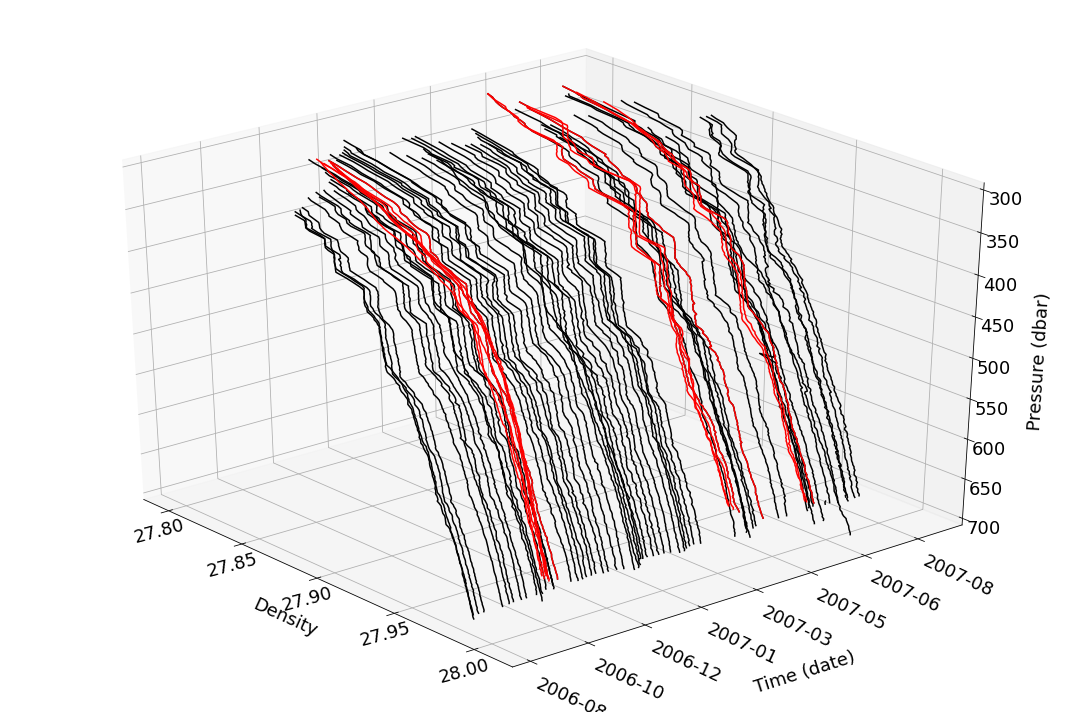

In [19]:
import matplotlib.dates as dates
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111,projection='3d')
tps = []
for t in dsi.time.values[::4]:
    ax.plot(dsi.Density.sel(time=t).values.reshape(dsi.sel(time=t).pressure.values.size,1),
            dsi.sel(time=t).pressure.values.reshape(dsi.sel(time=t).pressure.values.size,1),
            dates.date2num(t),'k',zdir='y'
            )
    tps.append(str(t)[:10])
ax.set_zlim(p1,p0)
#ax.set_yticks(Y)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
y = ax.get_yticks()
ax.set_yticklabels([dates.num2date(Y).strftime('%Y-%m') for Y in y])
plt.setp(ax.yaxis.get_majorticklabels(),rotation=-25,ha='left',rotation_mode='anchor');
plt.setp(ax.xaxis.get_majorticklabels(),rotation=15,ha='center',rotation_mode='anchor');
fig.tight_layout()
ax.set_xlabel('Density',labelpad=15);ax.set_ylabel('Time (date)',labelpad=50);
ax.set_zlabel('Pressure (dbar)',labelpad=15)
ax.view_init(30,-40)
for t in t_tbs:
    ax.plot(dsi.Density.sel(time=t).values.reshape(dsi.sel(time=t).pressure.values.size,1),
            dsi.sel(time=t).pressure.values.reshape(dsi.sel(time=t).pressure.values.size,1),
            dates.date2num(t),'r',zdir='y'
            )
print('Comment : A profile over 4 are plotted (except in detected eddies)')

### Fig2b

In [14]:
t_tbs

array(['2006-11-28T18:00:00.000000000', '2006-11-29T00:00:00.000000000',
       '2006-12-01T00:00:00.000000000', '2006-12-01T06:00:00.000000000',
       '2006-12-03T06:00:00.000000000', '2006-12-03T12:00:00.000000000',
       '2006-12-05T12:00:00.000000000', '2007-06-03T12:00:00.000000000',
       '2007-06-03T18:00:00.000000000', '2007-06-05T18:00:00.000000000',
       '2007-06-06T00:00:00.000000000', '2007-06-08T00:00:00.000000000',
       '2007-06-08T06:00:00.000000000', '2007-07-23T00:00:00.000000000',
       '2007-07-23T06:00:00.000000000', '2007-07-25T06:00:00.000000000',
       '2007-07-25T12:00:00.000000000'], dtype='datetime64[ns]')

Text(0.5, 0, 'Time (dates)')

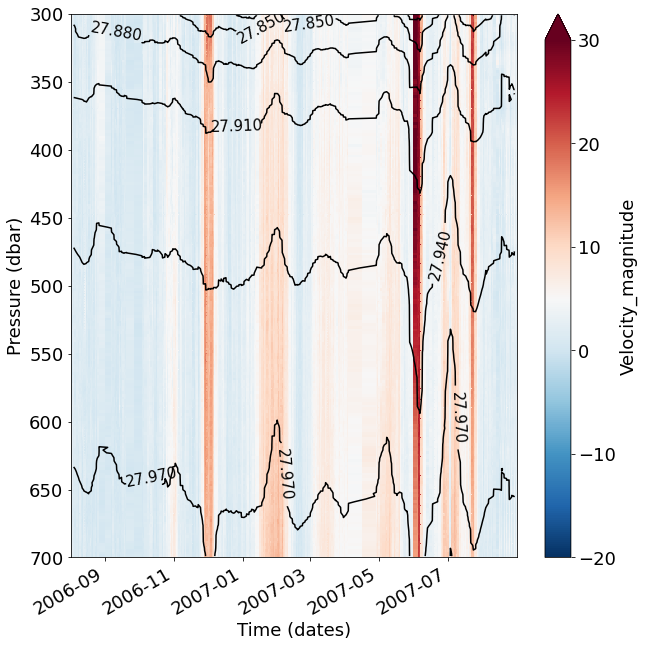

In [27]:
a0 = datetime.datetime(2006,10,26)
a1 = datetime.datetime(2006,11,2)
b0 = datetime.datetime(2004,7,15)
b1 = datetime.datetime(2004,8,2)
fig= plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
Ds['Velocity_magnitude'].sel(time=slice(datetime.datetime(2006,7,31),datetime.datetime(2007,8,31)),pressure=slice(300,700)).plot(ax=ax,y='pressure',yincrease=False,cmap='RdBu_r',vmin=-20,vmax=30,label='Velocity')
cs = Ds['Density'].sel(time=slice(datetime.datetime(2006,8,1),datetime.datetime(2007,9,1)),pressure=slice(300,700)).rolling(time=6, center=True).mean().dropna("time").plot.contour(ax=ax,colors='k',levels=8,y='pressure',yincrease=False)
plt.clabel(cs,inline=True,fontsize=15)
#ax.set_yticks(dates.date2num(datetime.datetime(2003,7,31)),dates.date2num(datetime.datetime(2003,8,31))
ax.set_ylabel('Pressure (dbar)');ax.set_xlabel('Time (dates)')
#plt.axvspan(a0, a1, color='grey', alpha=0.3, lw=0)
#plt.axvspan(b0, b1, color='grey', alpha=0.3, lw=0)
#var.plot(ax=ax)